In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_14_00_54
NN-MODEL FILENAME:  ./models/VBKG0BIX_14_00_54_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 200
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 200


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 7000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.925
LENGTH_ABS_MIN = 0.375

In [14]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 4
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  4


In [15]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate from original value
    scaling_factor = 0.8 + (1.8 - 0.8) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,     LENGTH_MAX,     LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = node_q_table[:,:,:,:, int(node_id*LO_GRAIN):int((node_id+1)*LO_GRAIN)]

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
    if iteration < 3:
        my_EPSILON   = (iteration+1) * 0.2 + np.random.uniform(-0.1,0.1)
    else:
        my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES   ])



# GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES , -1).astype(np.float16)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 47394.21 MiB, increment: 43346.84 MiB
Quantization TIME:  0.38 minutes


In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
MEAN TABULAR EPSILON =  0.2
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 59373 EXPERIENCES:0:00:13.516575


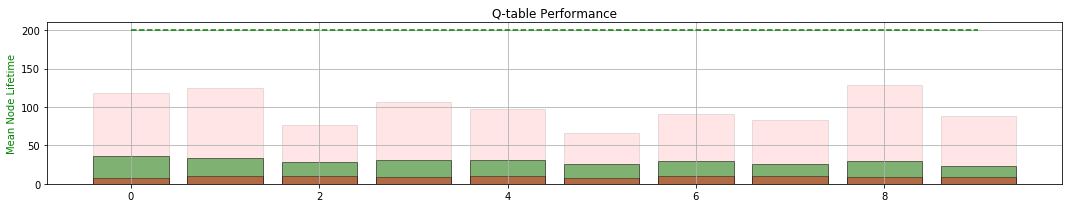

GOOD MEMORY COUNTER:  57373
BAD MEMORY COUNTER:  2000
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  197.59
Validating... MEAN TIME:  198.07
Validating... MEAN TIME:  197.36
Validating... MEAN TIME:  196.06
Validating... MEAN TIME:  195.59
TRAINING TIME:0:00:48.836849


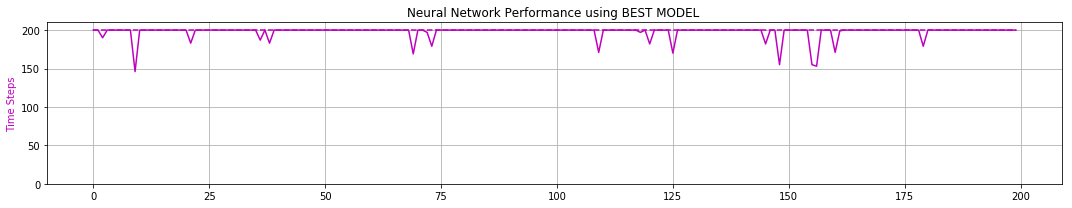

peak memory: 48087.11 MiB, increment: 43597.97 MiB
Quantization TIME:  0.38 minutes


ITERATION # 1
MEAN TABULAR EPSILON =  0.4
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 1: 9
REAL TIME TO GENERATE 128786 EXPERIENCES:0:00:16.184096


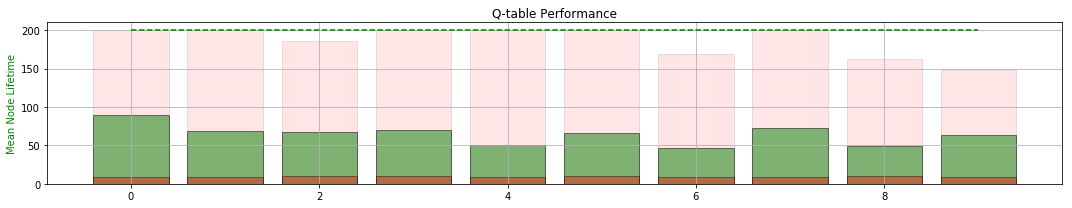

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  3989
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  195.405
Validating... MEAN TIME:  181.135
Validating... MEAN TIME:  191.935
Validating... MEAN TIME:  180.005
Validating... MEAN TIME:  185.24
TRAINING TIME:0:00:46.289321


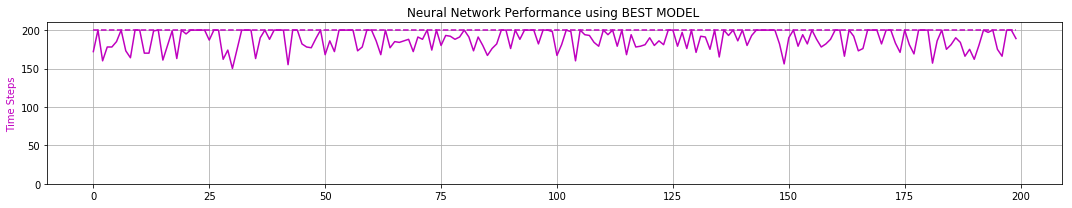

peak memory: 48591.86 MiB, increment: 43674.19 MiB
Quantization TIME:  0.37 minutes


ITERATION # 2
MEAN TABULAR EPSILON =  0.6000000000000001
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 2: 9
REAL TIME TO GENERATE 199553 EXPERIENCES:0:00:23.019830


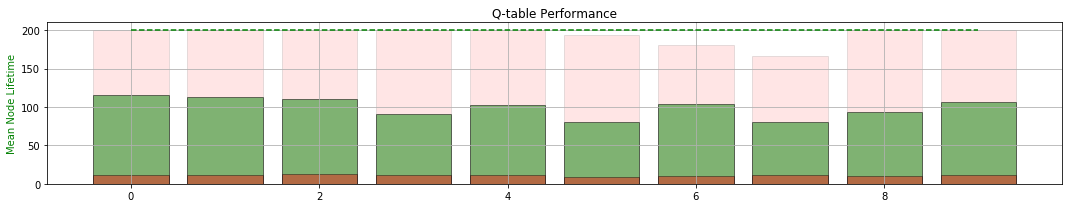

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  5969
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  156.175
Validating... MEAN TIME:  173.8
Validating... MEAN TIME:  154.795
Validating... MEAN TIME:  162.155
Validating... MEAN TIME:  153.95
TRAINING TIME:0:00:41.433975


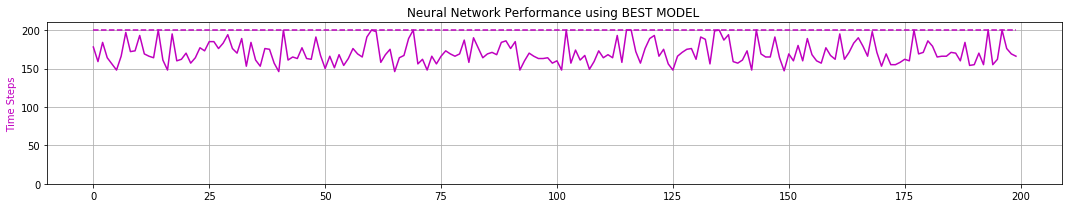

peak memory: 48155.65 MiB, increment: 43195.18 MiB
Quantization TIME:  0.38 minutes


ITERATION # 3
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 3: 126
REAL TIME TO GENERATE 298790 EXPERIENCES:0:00:32.060202


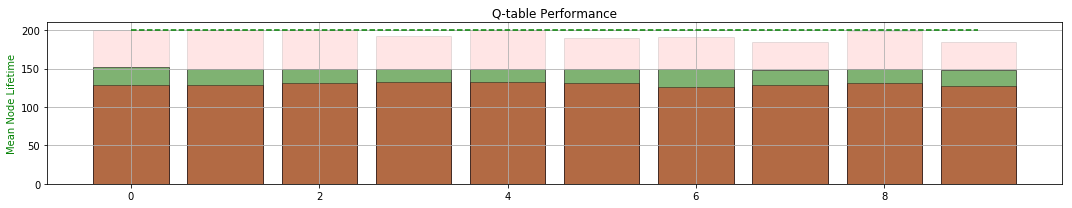

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  7961
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  154.42
Validating... MEAN TIME:  133.77
Validating... MEAN TIME:  150.115
Validating... MEAN TIME:  128.465
Validating... MEAN TIME:  150.02
TRAINING TIME:0:00:38.693762


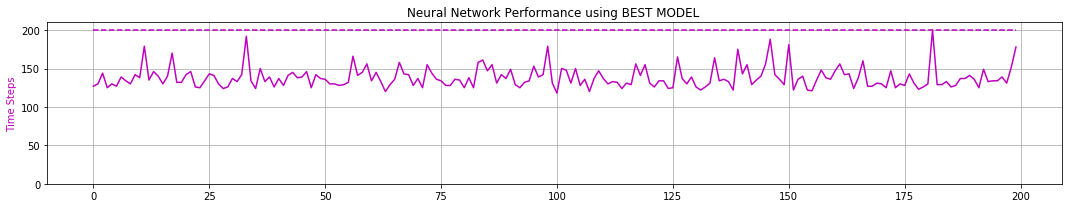

peak memory: 48302.91 MiB, increment: 43257.73 MiB
Quantization TIME:  0.38 minutes


ITERATION # 4
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 4: 112
REAL TIME TO GENERATE 284067 EXPERIENCES:0:00:25.895139


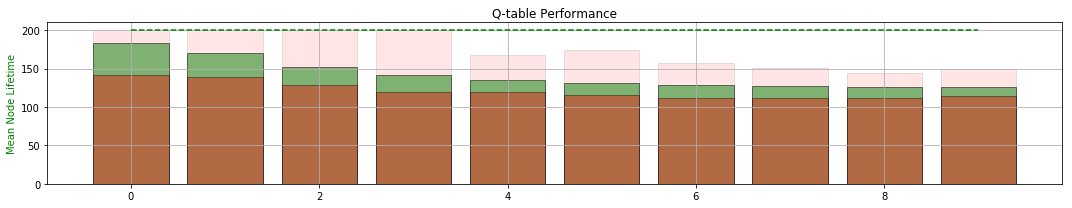

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  9858
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  174.615
Validating... MEAN TIME:  168.19
Validating... MEAN TIME:  187.12
Validating... MEAN TIME:  164.22
Validating... MEAN TIME:  162.345
TRAINING TIME:0:00:43.927155


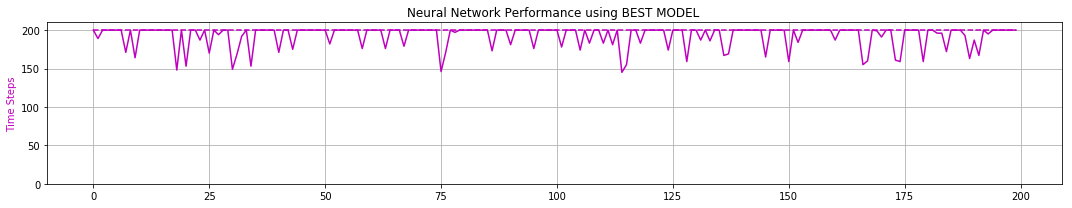

peak memory: 48222.38 MiB, increment: 43167.55 MiB
Quantization TIME:  0.37 minutes


ITERATION # 5
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 5: 182
REAL TIME TO GENERATE 399972 EXPERIENCES:0:00:44.900111


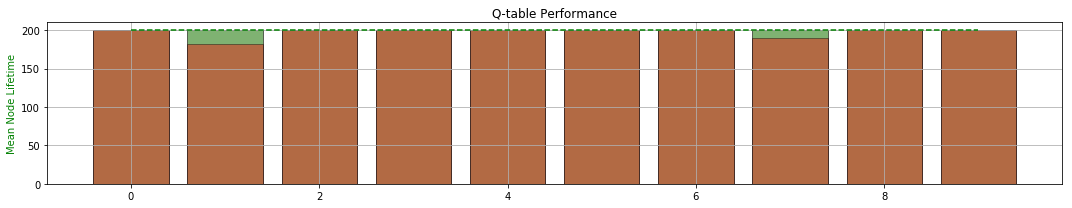

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  9860
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.83
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:48.180672


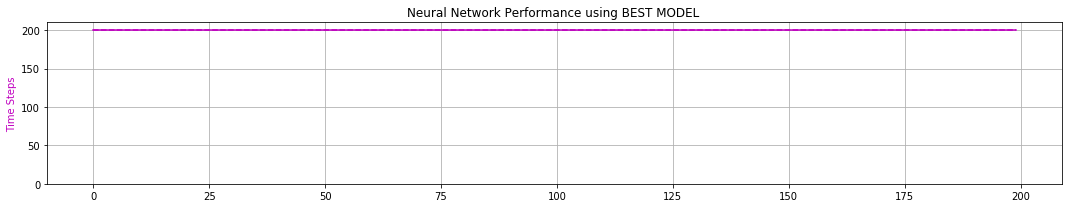

peak memory: 48263.14 MiB, increment: 43181.70 MiB
Quantization TIME:  0.37 minutes


ITERATION # 6
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 6: 181
REAL TIME TO GENERATE 399898 EXPERIENCES:0:00:41.408892


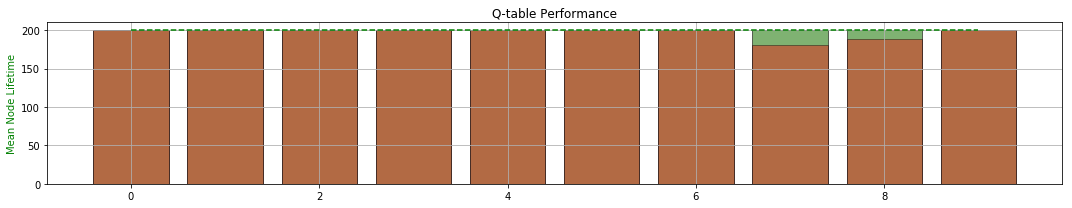

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  9875
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.135
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:49.406440


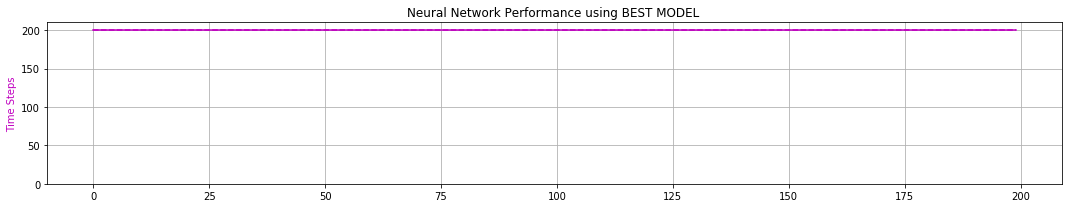

peak memory: 48869.45 MiB, increment: 43739.38 MiB
Quantization TIME:  0.38 minutes


ITERATION # 7
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 7: 178
REAL TIME TO GENERATE 397261 EXPERIENCES:0:00:41.166814


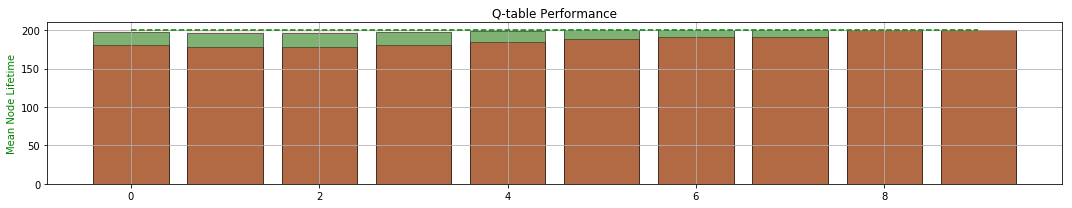

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  10229
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  198.53
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.99
Validating... MEAN TIME:  194.595
TRAINING TIME:0:00:48.264828


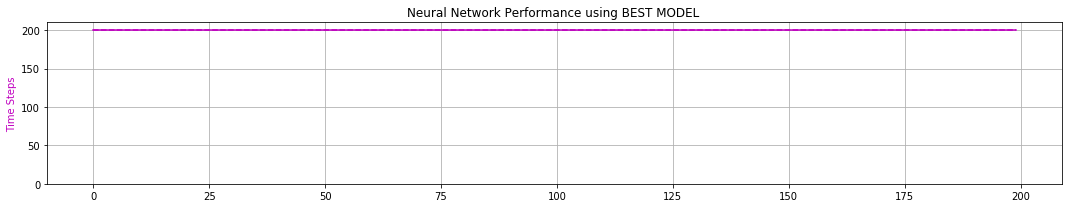

peak memory: 48854.25 MiB, increment: 43749.84 MiB
Quantization TIME:  0.37 minutes


ITERATION # 8
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 8: 173
REAL TIME TO GENERATE 394521 EXPERIENCES:0:00:40.004503


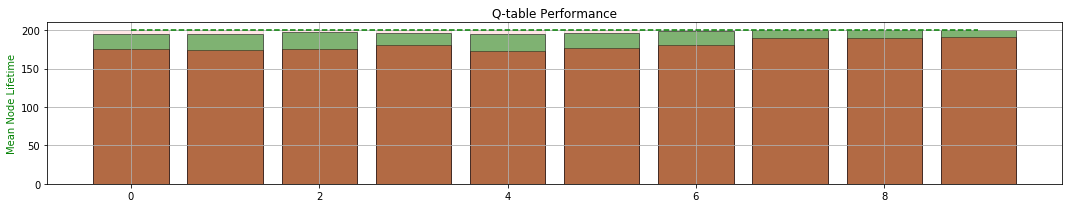

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  10982
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  186.565
Validating... MEAN TIME:  188.065
Validating... MEAN TIME:  195.77
Validating... MEAN TIME:  198.28
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:48.314467


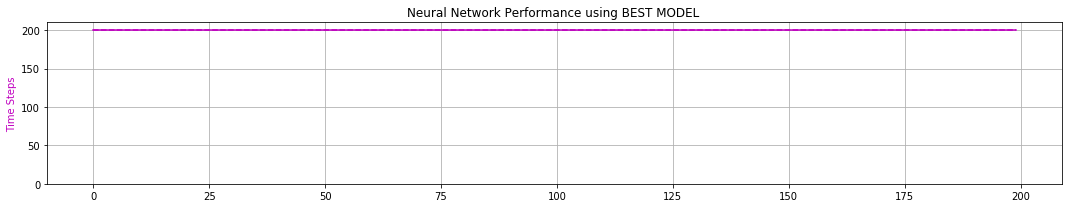

peak memory: 48261.79 MiB, increment: 43166.80 MiB
Quantization TIME:  0.38 minutes


ITERATION # 9
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 9: 175
REAL TIME TO GENERATE 393094 EXPERIENCES:0:00:40.079464


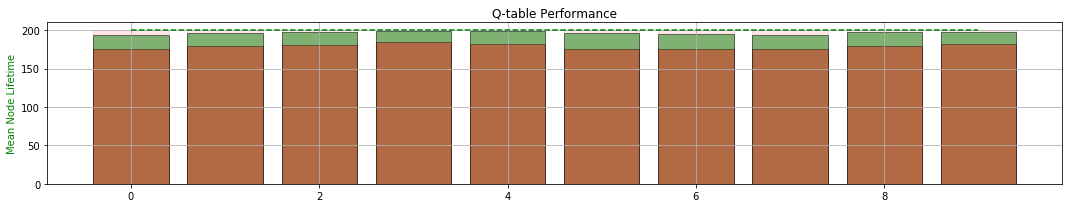

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  11818
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.925
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.225
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  190.975
TRAINING TIME:0:00:49.073413


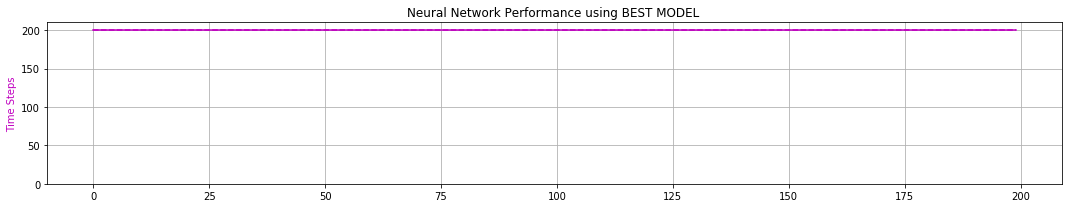

peak memory: 48466.00 MiB, increment: 43290.18 MiB
Quantization TIME:  0.37 minutes


ITERATION # 10
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 10: 149
REAL TIME TO GENERATE 371771 EXPERIENCES:0:00:35.563185


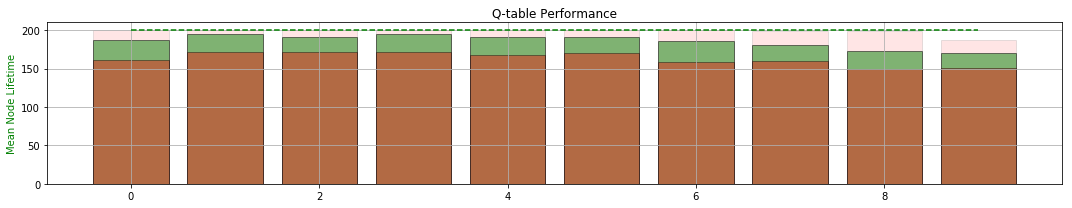

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  13431
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.7
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.88
Validating... MEAN TIME:  199.15
TRAINING TIME:0:00:48.604420


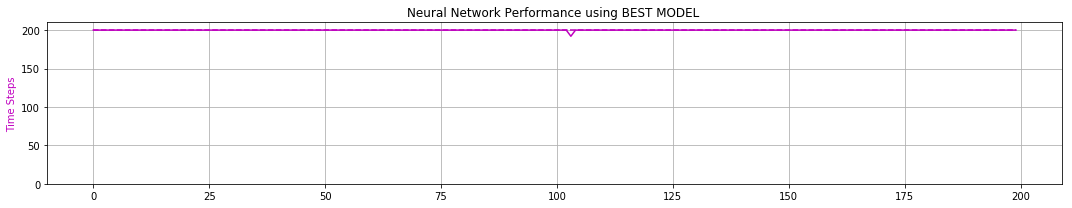

peak memory: 48676.57 MiB, increment: 43567.61 MiB
Quantization TIME:  0.37 minutes


ITERATION # 11
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 11: 167
REAL TIME TO GENERATE 399855 EXPERIENCES:0:00:41.622504


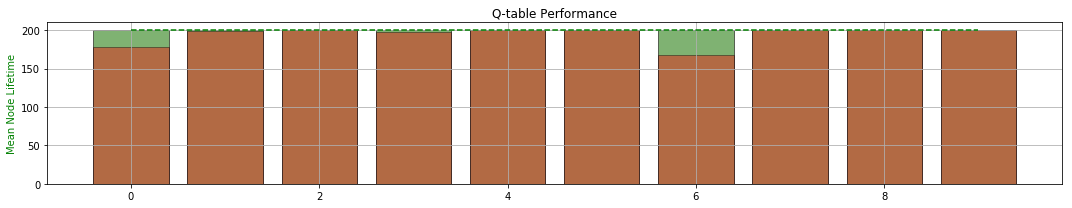

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  13446
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.99
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:49.532358


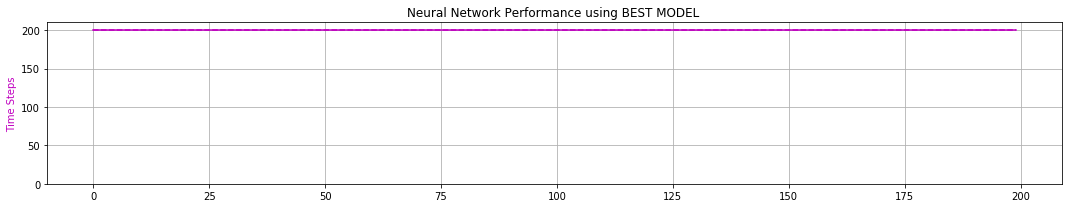

peak memory: 48367.80 MiB, increment: 43238.46 MiB
Quantization TIME:  0.37 minutes


ITERATION # 12
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 12: 166
REAL TIME TO GENERATE 397917 EXPERIENCES:0:00:41.267557


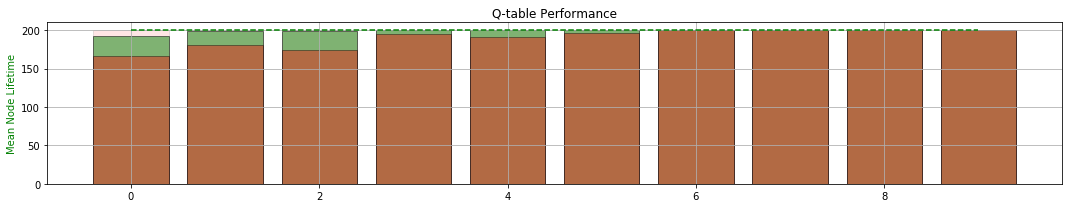

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  13669
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.65
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:49.149692


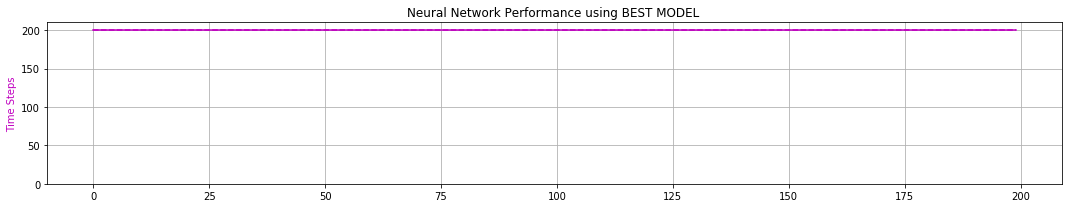

peak memory: 48796.69 MiB, increment: 43701.98 MiB
Quantization TIME:  0.37 minutes


ITERATION # 13
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 13: 172
REAL TIME TO GENERATE 394603 EXPERIENCES:0:00:40.854724


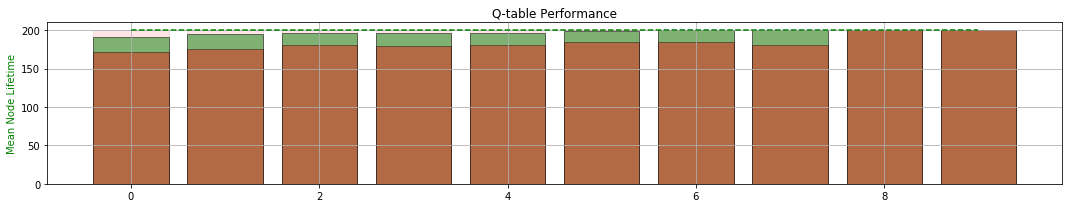

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  14312
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  186.64
Validating... MEAN TIME:  197.505
Validating... MEAN TIME:  193.425
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:47.888940


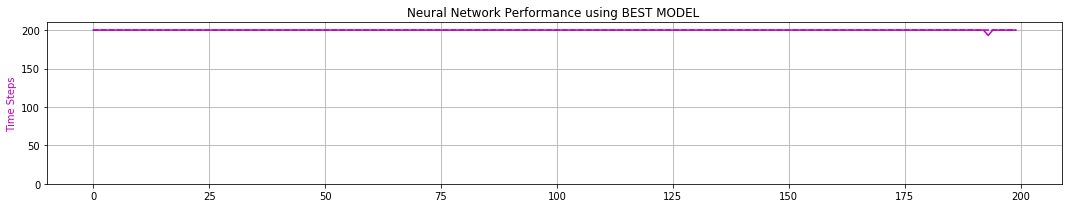

peak memory: 48769.79 MiB, increment: 43639.29 MiB
Quantization TIME:  0.37 minutes


ITERATION # 14
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 14: 159
REAL TIME TO GENERATE 377188 EXPERIENCES:0:00:37.111874


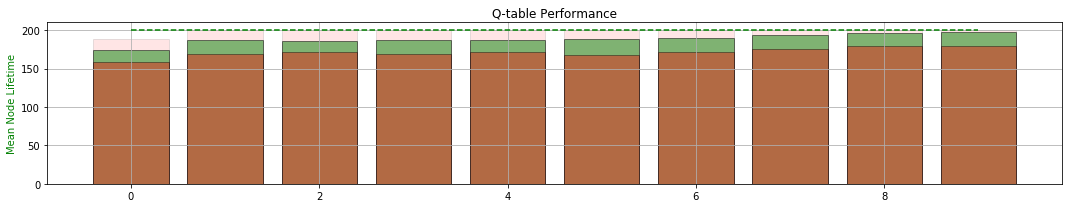

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  15916
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  196.865
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.205
Validating... MEAN TIME:  168.625
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:48.003681


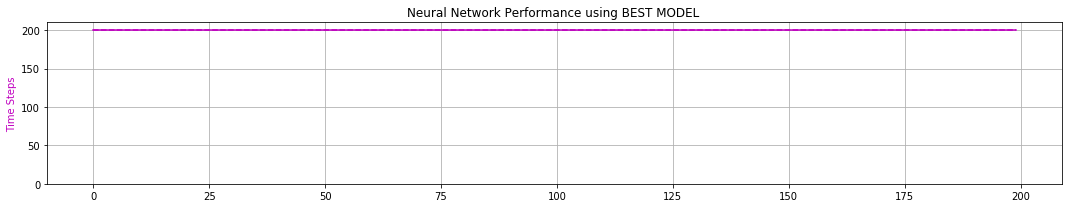

peak memory: 48694.43 MiB, increment: 43560.53 MiB
Quantization TIME:  0.38 minutes


ITERATION # 15
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 15: 153
REAL TIME TO GENERATE 354851 EXPERIENCES:0:00:32.883907


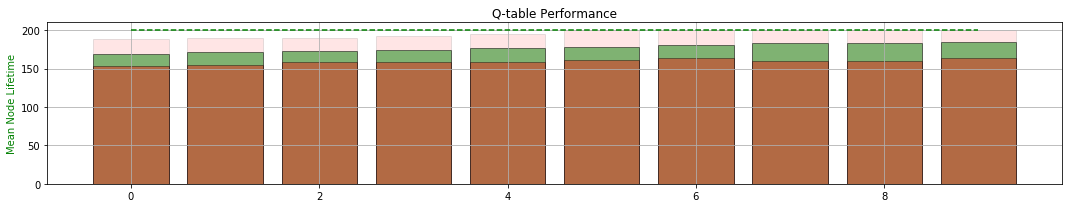

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  17877
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  179.7
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  177.745
Validating... MEAN TIME:  172.305
TRAINING TIME:0:00:46.974658


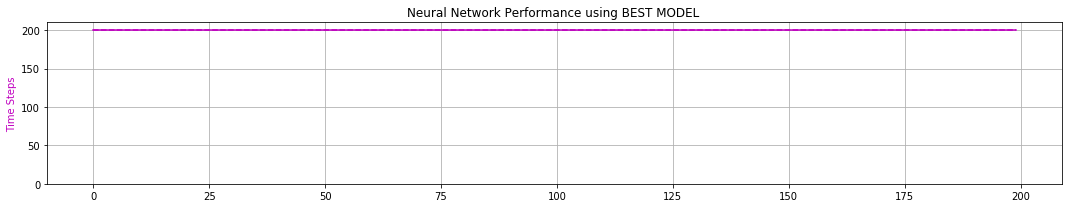

peak memory: 48620.77 MiB, increment: 43569.17 MiB
Quantization TIME:  0.37 minutes


ITERATION # 16
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 16: 143
REAL TIME TO GENERATE 330994 EXPERIENCES:0:00:29.851231


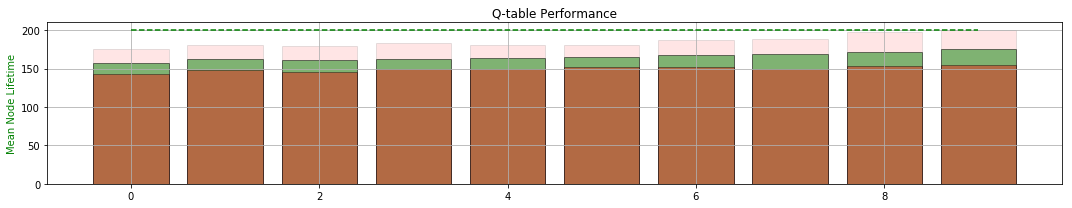

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  19874
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  149.37
Validating... MEAN TIME:  157.985
Validating... MEAN TIME:  166.025
Validating... MEAN TIME:  164.675
Validating... MEAN TIME:  168.96
TRAINING TIME:0:00:42.260981


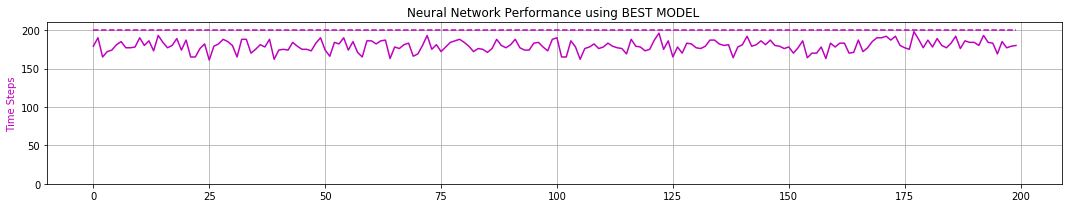

peak memory: 48496.27 MiB, increment: 43371.11 MiB
Quantization TIME:  0.38 minutes


ITERATION # 17
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 17: 124
REAL TIME TO GENERATE 290953 EXPERIENCES:0:00:23.847541


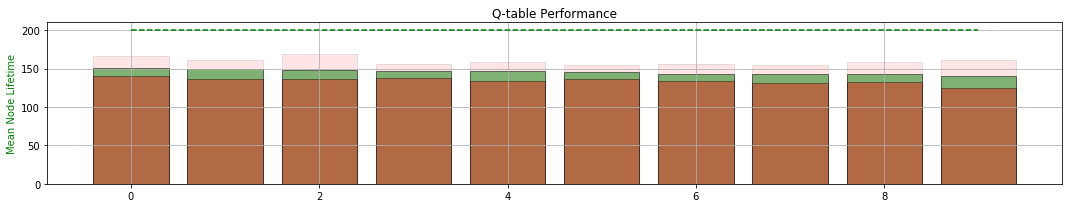

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  21874
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  148.285
Validating... MEAN TIME:  153.775
Validating... MEAN TIME:  158.265
Validating... MEAN TIME:  143.865
Validating... MEAN TIME:  155.495
TRAINING TIME:0:00:40.037611


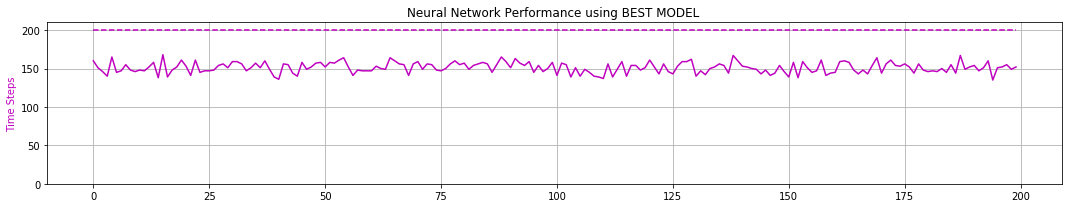

peak memory: 48377.34 MiB, increment: 43327.10 MiB
Quantization TIME:  0.38 minutes


ITERATION # 18
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 18: 111
REAL TIME TO GENERATE 252790 EXPERIENCES:0:00:21.079024


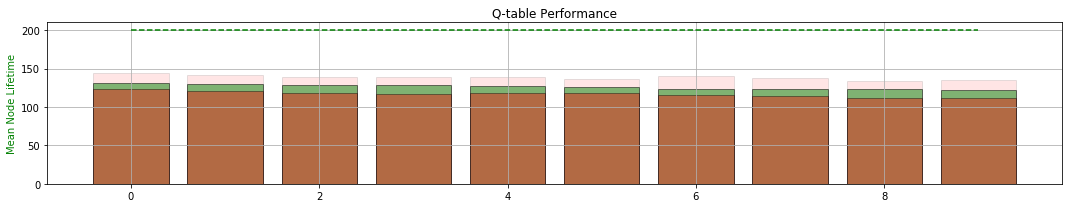

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  23874
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  137.395
Validating... MEAN TIME:  137.735
Validating... MEAN TIME:  146.13
Validating... MEAN TIME:  148.96
Validating... MEAN TIME:  171.26
TRAINING TIME:0:00:39.704621


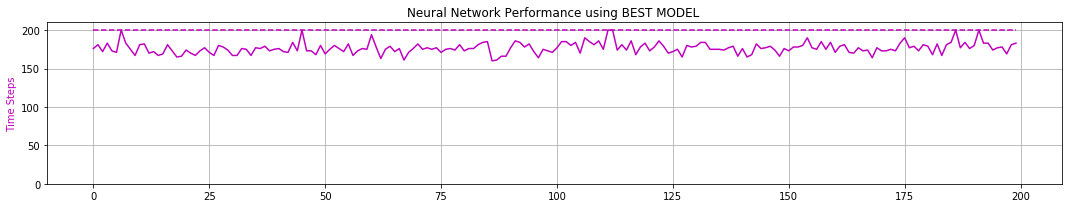

peak memory: 48664.14 MiB, increment: 43577.45 MiB
Quantization TIME:  0.38 minutes


ITERATION # 19
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 19: 116
REAL TIME TO GENERATE 265428 EXPERIENCES:0:00:21.633901


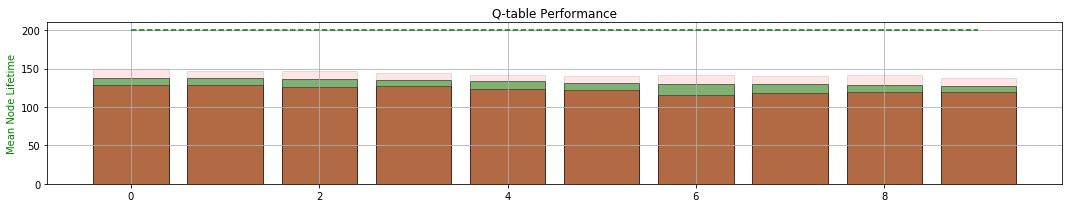

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  25874
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  159.59
Validating... MEAN TIME:  156.635
Validating... MEAN TIME:  155.645
Validating... MEAN TIME:  153.04
Validating... MEAN TIME:  164.505
TRAINING TIME:0:00:41.655092


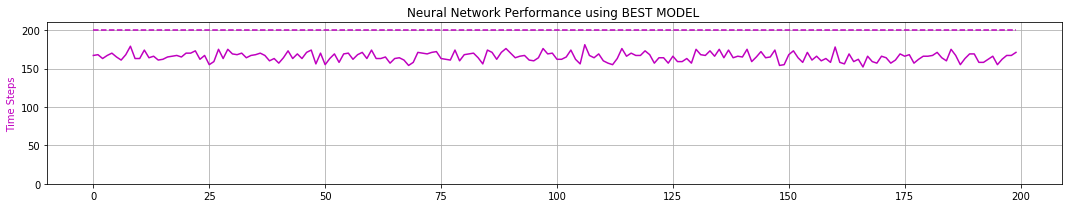

peak memory: 48852.79 MiB, increment: 43740.67 MiB
Quantization TIME:  0.38 minutes


ITERATION # 20
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 20: 50
REAL TIME TO GENERATE 271205 EXPERIENCES:0:00:22.400980


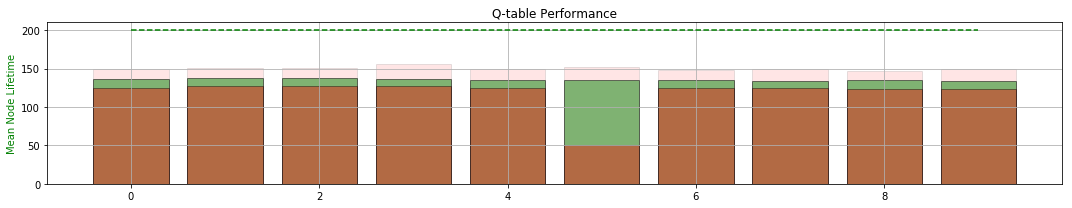

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  27874
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  137.535
Validating... MEAN TIME:  150.86
Validating... MEAN TIME:  176.725
Validating... MEAN TIME:  171.045
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:43.658244


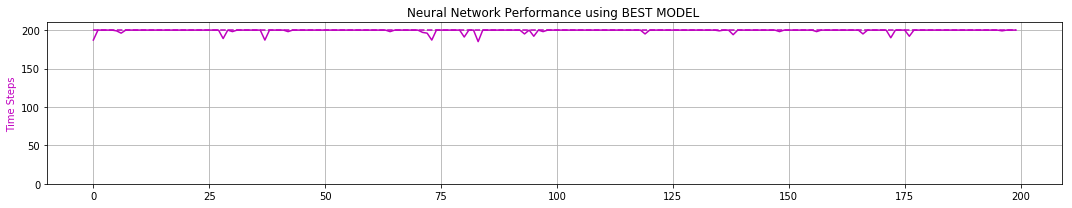

peak memory: 48778.03 MiB, increment: 43740.12 MiB
Quantization TIME:  0.38 minutes


ITERATION # 21
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 21: 138
REAL TIME TO GENERATE 322215 EXPERIENCES:0:00:28.094076


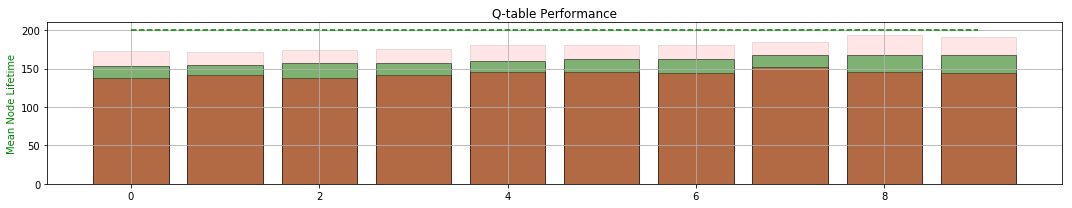

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  29874
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  172.97
Validating... MEAN TIME:  170.325
Validating... MEAN TIME:  146.99
Validating... MEAN TIME:  148.535
Validating... MEAN TIME:  157.965
TRAINING TIME:0:00:41.542532


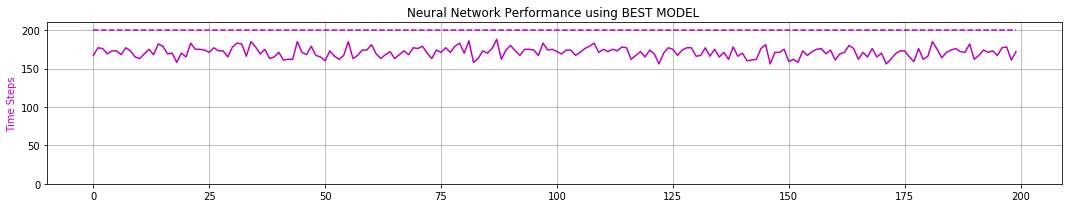

peak memory: 48522.48 MiB, increment: 43459.40 MiB
Quantization TIME:  0.38 minutes


ITERATION # 22
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 22: 129
REAL TIME TO GENERATE 289395 EXPERIENCES:0:00:23.538025


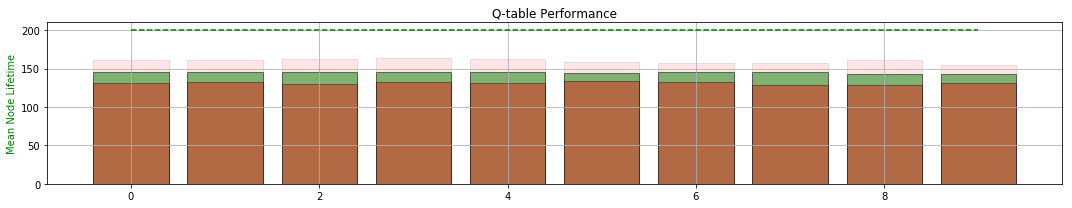

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  31874
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  139.58
Validating... MEAN TIME:  143.745
Validating... MEAN TIME:  146.96
Validating... MEAN TIME:  137.86
Validating... MEAN TIME:  151.66
TRAINING TIME:0:00:38.704734


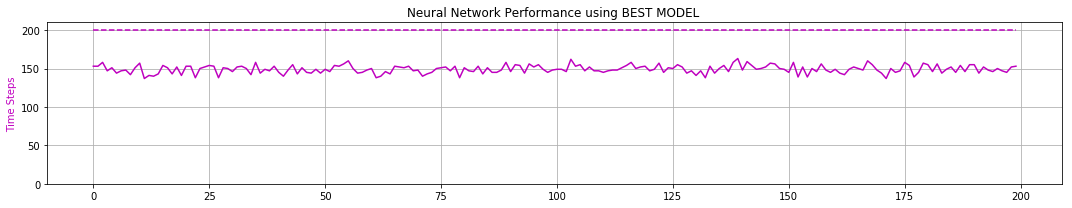

peak memory: 48525.07 MiB, increment: 43408.48 MiB
Quantization TIME:  0.38 minutes


ITERATION # 23
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 23: 121
REAL TIME TO GENERATE 266948 EXPERIENCES:0:00:21.977036


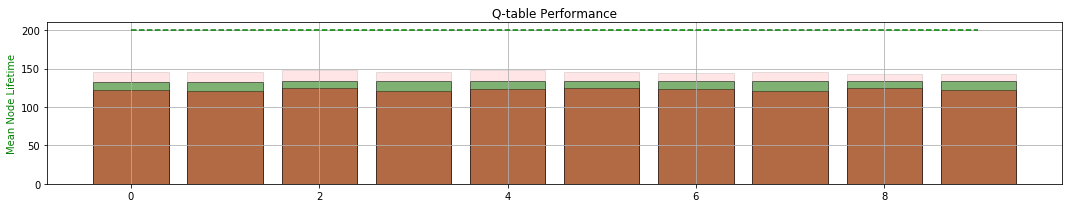

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  33874
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  137.08
Validating... MEAN TIME:  156.31
Validating... MEAN TIME:  142.555
Validating... MEAN TIME:  136.925
Validating... MEAN TIME:  135.775
TRAINING TIME:0:00:37.712472


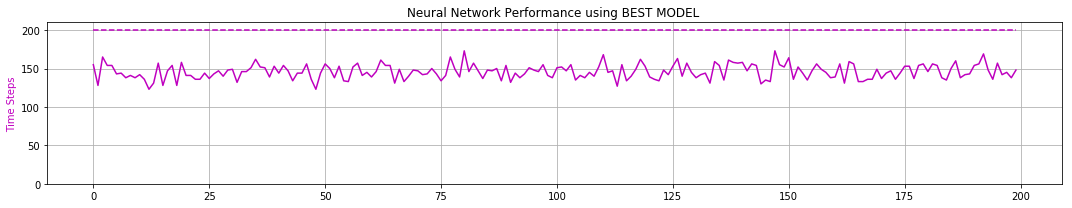

peak memory: 48349.52 MiB, increment: 43233.04 MiB
Quantization TIME:  0.37 minutes


ITERATION # 24
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 24: 116
REAL TIME TO GENERATE 267654 EXPERIENCES:0:00:23.030814


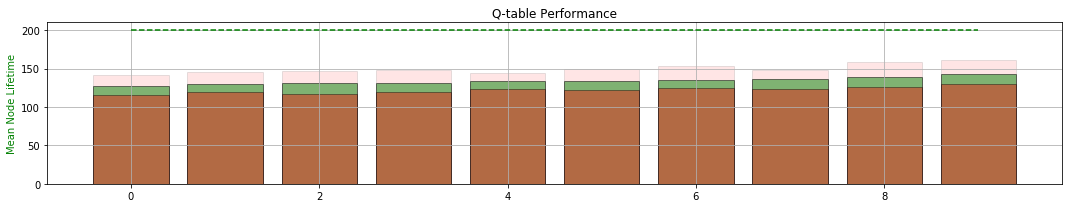

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  35874
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  137.985
Validating... MEAN TIME:  160.24
Validating... MEAN TIME:  138.235
Validating... MEAN TIME:  153.31
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:40.378484


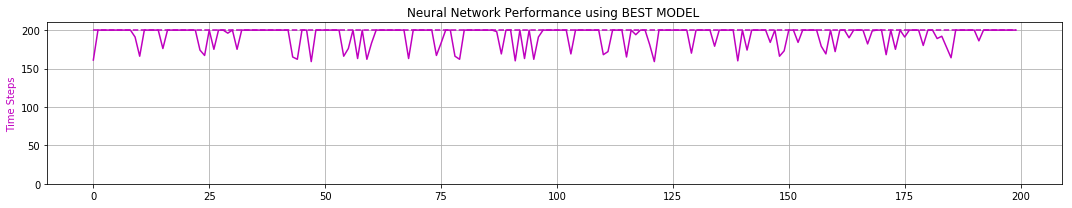

peak memory: 48313.53 MiB, increment: 43197.08 MiB
Quantization TIME:  0.38 minutes


ITERATION # 25
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 25: 131
REAL TIME TO GENERATE 358604 EXPERIENCES:0:00:34.054801


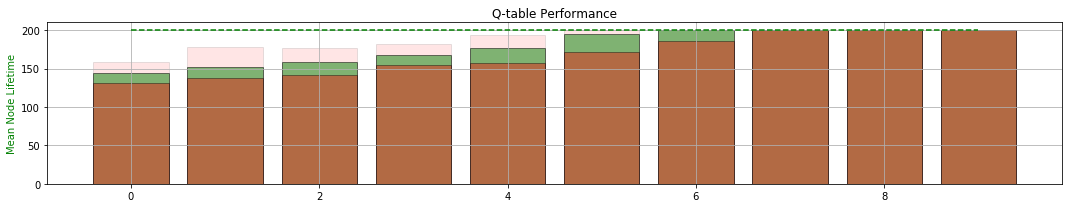

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  36969
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  193.525
Validating... MEAN TIME:  145.41
Validating... MEAN TIME:  186.915
Validating... MEAN TIME:  150.91
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:45.235075


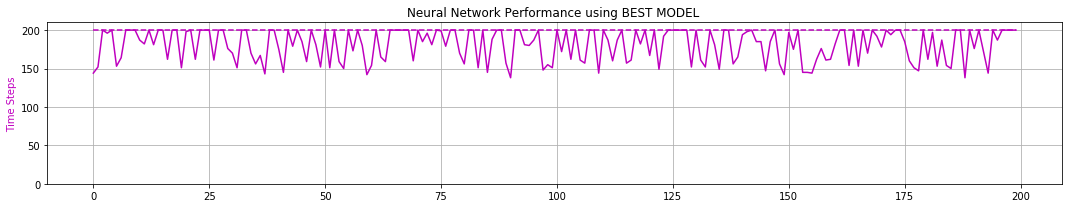

In [ ]:
while iteration < MAX_NO_OF_ITERATIONS:
    if iteration < 3:
        node_EPSILON   = (iteration+1) * 0.2
    else:
        node_EPSILON   = T_EPSILON
    
    print("\n")
    print("ITERATION #", iteration)
    print("MEAN TABULAR EPSILON = ", node_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES , -1).astype(np.float16)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
#     for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
#         print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
#         print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
#         print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [ ]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

In [ ]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [ ]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))